In [223]:
%matplotlib inline

import pickle

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Scikit imports
from sklearn.datasets import make_classification, make_regression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.metrics import accuracy_score, mean_squared_error

In [362]:
# Code hider, source: http://chris-said.io/2016/02/13/how-to-make-polished-jupyter-presentations-with-optional-code-visibility/
from IPython.display import HTML

HTML('''
<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>
''')

# Overfitting notebook

Notebook for overfitting simulation and notes.

## Functions

### Data Generation

In [4]:
def generate_class_data(n_train, n_test, **kwargs):
    """Creates synthetic dataset for classification.
    
    Mainly a wrapper for sklearn.datasets.make_classification.
    
    Args:
        n_train (int): number of training samples
        n_test (int): number of testing samples
    
    Returns:
        (np.ndarray, np.ndarray, np.ndarray, np.ndarray): train_X, train_y, test_X, test_y
    
    """
    
    n_samples = n_train + n_test
    
    X, y = make_classification(n_samples = n_samples, **kwargs)
    
    train_X = X[:n_train, :]
    train_y= y[:n_train]

    test_X = X[n_train:, :]
    test_y = y[n_train:]
    
    return train_X, train_y, test_X, test_y


def generate_reg_data(n_train, n_test, **kwargs):
    """Creates a synthetic dataset for regression.
    
    Mainly a wrapper for sklearn.datasets.make_regression.
    
    Args:
        n_train (int): number of training samples
        n_test (int): number of testing samples
    
    Returns:
        (np.ndarray, np.ndarray, np.ndarray, np.ndarray): train_X, train_y, test_X, test_y
    """

    n_samples = n_train + n_test
    reg_X, reg_y = make_regression(n_samples=n_samples, **kwargs)

    reg_train_X = reg_X[:n_train, :]
    reg_train_y= reg_y[:n_train]

    reg_test_X = reg_X[n_train:, :]
    reg_test_y = reg_y[n_train:]

    return reg_train_X, reg_train_y, reg_test_X, reg_test_y
    
    
def generate_noise_class_data(n_train, n_test, n_features, p=0.5, random_state=0):
    """Generates a random classification data set.
    
    Features are drawn from a multivariate normal with 0 mean and unit variance.
    
    Labels are drawn from a Bernoulli distribution with P(yes) = p.
    
    Args:
        n_train (int): number of training samples
        n_test (int): number of testing samples
        n_features (int): number of features 
        p: Bernoulli parameter
        random_state (int): random state for reproducibility
        
    Returns:
        (np.ndarray, np.ndarray, np.ndarray, np.ndarray): train_X, train_y, test_X, test_y
    """
    
    np.random.seed(random_state)
    train_X = np.random.multivariate_normal(np.zeros((n_features)), 
                                      cov=np.eye(n_features),
                                      size=n_train)
    
    train_y = np.random.rand(n_train) < p
    
    test_X =  np.random.multivariate_normal(np.zeros((n_features)), 
                                      cov=np.eye(n_features),
                                      size=n_test)
    test_y = np.random.rand(n_test) < p
    
    return train_X, train_y, test_X, test_y


def generate_noise_reg_data(n_train, n_test, n_features, mu=1, random_state=0):
    """Generates a random regression data set.
    
    Features are drawn from a multivariate normal with 0 mean and unit variance.
    
    Labels are drawn from a normal distribution with mean mu and unit variance
    
    Args:
        n_train (int): number of training samples
        n_test (int): number of testing samples
        n_features (int): number of features 
        mu: mean of the response label
        random_state (int): random state for reproducibility
        
    Returns:
        (np.ndarray, np.ndarray, np.ndarray, np.ndarray): train_X, train_y, test_X, test_y
    """
    
    np.random.seed(random_state)
    train_X = np.random.multivariate_normal(np.zeros((n_features)), 
                                      cov=np.eye(n_features),
                                      size=n_train)
    
    train_y = np.random.normal(loc=mu, scale=1, size=n_train)
    
    test_X =  np.random.multivariate_normal(np.zeros((n_features)), 
                                      cov=np.eye(n_features),
                                      size=n_test)
    test_y = np.random.normal(loc=mu, scale=1, size=n_test)
    
    return train_X, train_y, test_X, test_y



def simulate_no_label_X(pipelines, n_feats, n_trials, n_samples, classification=True):
    """Runs an n_trials simulation the given pipeline models on unlabeled, randomly drawn X.
    
    Features are sampled from a multivariate Gaussian with random [0,1] means and unit variance.
    
    Args:
        pipelines (list): list of sklearn.pipeline.Pipelines with trained models
        n_feats (int): the number of features for the Xs
        n_trials (int): number of trials to run.
        n_samples (int): number of samples to draw per run.
        classification (bool): whether to evaluate with classification or regression metrics.
        
    Returns:
        (list, list): list of mean probabilities predicting label 1, list of corresponding std dev
    """
    # n_trials by n_models
    #stds = np.zeros((n_trials, len(pipelines)))
    pred_probs = np.zeros((n_trials, len(pipelines)))
    
    for trial in range(n_trials):
        no_label_X = np.random.multivariate_normal(np.random.rand((n_feats)), 
                                           cov=np.eye(n_feats),
                                           size=n_samples)
        
        for pipe_idx, pipe in enumerate(pipelines):
            pred_prob = np.mean(pipe.predict_proba(no_label_X)[:, 1])
            pred_probs[trial, pipe_idx] = pred_prob
        
        print("trial {} complete".format(trial))
    mean_probs = np.mean(pred_probs, axis=0)
    std_probs = np.std(pred_probs, axis=0)
    assert len(pipelines) == len(mean_probs)
    assert len(pipelines) == len(std_probs)
    
    return pred_probs, mean_probs, std_probs




### Plotting

In [464]:
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import ks_2samp
import statsmodels.api as sm

# functions
def build_prob_plot(probas, title, n_rows, n_cols, labels, format_str):
    """Builds sns.distplots for the given probabilities.
    
    Args:
        probas (np.ndarray): probabilities to plot
        title (str)
    """

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(10,5), sharex=True)
    axes = axes.flat
    for idx, prob in enumerate(probas):
        # TODO parameterize this later
        axes[idx].set(ylim=(0,5), title=format_str.format(labels[idx]))
        sns.distplot(prob, bins=np.arange(0, 1.1, 0.05), ax=axes[idx])

    plt.suptitle(title, fontsize=18)
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)

    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    plt.xlabel("P(y=1 | x)")
    plt.ylabel("density (area sums to 1)")
    plt.show()
    
def build_cdf_plot(train_probas, test_probas, title, n_rows, n_cols, labels, format_str, fig_size=(10,5)):
    """Builds sns.distplots for the given probabilities' CDFs.
    
    Args:
        probas (np.ndarray): probabilities to plot
        title (str)
    """

    fig, axes = plt.subplots(n_rows, n_cols, figsize=fig_size, sharex=True)
    axes = axes.flat
    for idx in range(train_probas.shape[0]):
        train_prob = train_probas[idx, :]
        test_prob = test_probas[idx, :]
        axes[idx].set(ylim=(-0.1,1.1), title=format_str.format(labels[idx]))
        ecdf_train = sm.distributions.ECDF(train_prob)
        ecdf_test = sm.distributions.ECDF(test_prob)
        x = np.linspace(0,1)
        sns.lineplot(x, ecdf_train(x), ax=axes[idx], label="train")
        sns.lineplot(x, ecdf_test(x), ax=axes[idx], label="test")

    axes[-1].legend()
    handles, labels = axes[-1].get_legend_handles_labels()

    fig.legend(handles, labels, loc='upper right')
    plt.suptitle(title, fontsize=18)
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)

    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    plt.xlabel("P(X <= x)")
    #plt.ylabel("density (area sums to 1)")
    #plt.legend()
    plt.show()

#### `make_classification`

- clusters of points normally distributed with $\sigma=1$ about vertices of an `n_informative`-dimensional hypercube with sides of length 2*`class_sep`

## KS-Test Simulations

### The Game

- we are given a model, as well as a distribution of probabilities of classifications on the training data
- we can make draws from the underlying data distribution, albeit with no labels. Can we determine whether or not the model overfit?

#### Notes
- accuracy/precision/recall for the overfitted model can be higher than that of the non-overfitted model, as they rely on a probability threshold choice that does not take into account whether the train/test distributions are consistent

### 2-sample KS test

Let $X_1,...,X_m$ be a sample of size $m$ has distribution with CDF $F(x)$ while a second sample $Y_1,...,Y_n$ of size $n$ has distribution with CDF $G(x)$. We wish to test:

$$
H_0: F = G
$$

Let= $F_m(x)$ and $G_n(x)$ be corresponding empirical CDFs. We then calculate the test statistic:

$$
D_{mn} = \sqrt{\frac{mn}{m+n}} \sup_x | F_m(x) - G_n(x)|
$$

### Logistic Regression, noise

- \# train = 500
- \# test = 500
- \# features = 200
- balanced classes

In [390]:
# samples
n_train = 500
n_test = 500
n_features = 200

p = 0.5

regularization = np.logspace(-8, 0, num=10, base=10)

n_trials = 100


train_probs = np.zeros((n_trials, len(regularization), n_train))
test_probs = np.zeros((n_trials, len(regularization), n_test))
train_acc = np.zeros((n_trials, len(regularization)))
test_acc = np.zeros((n_trials, len(regularization)))



for idx, reg in enumerate(regularization):
    for trial in range(n_trials):
        # generate data
        train_X, train_y, \
        test_X, test_y = generate_noise_class_data(n_train,
                                                   n_test,
                                                   n_features,
                                                   p,
                                                   random_state=trial)
        clf = LogisticRegression(solver='lbfgs', 
                                 penalty='l2',
                                 C=reg,
                                 max_iter=500)
        clf.fit(train_X, train_y)

        train_acc[trial, idx] = clf.score(train_X, train_y)
        test_acc[trial, idx] = clf.score(test_X, test_y)

        train_probs[trial, idx, :] = clf.predict_proba(train_X)[:, 0]
        test_probs[trial, idx, :] = clf.predict_proba(test_X)[:, 0] 

In [391]:
df = pd.DataFrame(columns=['reg', 'test_stat', 'p_val', 'train_acc', 'test_acc'])
for i, reg in enumerate(regularization):
    for trial in range(n_trials):
        D_test_stat, p_val = ks_2samp(train_probs[trial, i,:], test_probs[trial, i,:])
        df.loc[(i * n_trials) + trial] = [reg, D_test_stat, p_val, train_acc[trial, i], test_acc[trial, i]]

#### KS test

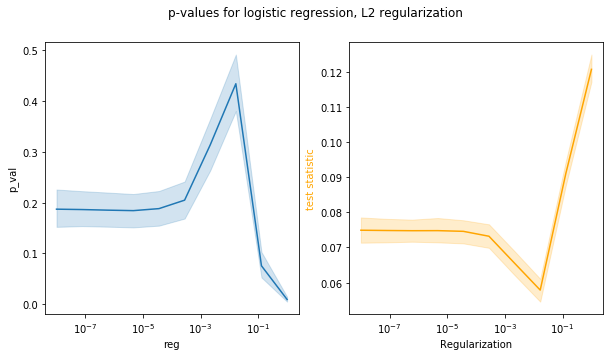

In [392]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5), sharex=True)

sns.lineplot(x='reg', y='p_val', data=df, ax=ax1)
ax1.set_xscale('log')
plt.ylabel("p-value", color='blue')
#plt.title("KS test stat for logistic regression, L2 regularization")

sns.lineplot(x='reg', y='test_stat', color='orange', data=df, ax=ax2)
ax2.set_xscale('log')
plt.ylabel("test statistic", color='orange')
plt.suptitle("p-values for logistic regression, L2 regularization")
plt.xlabel("Regularization")

plt.show()


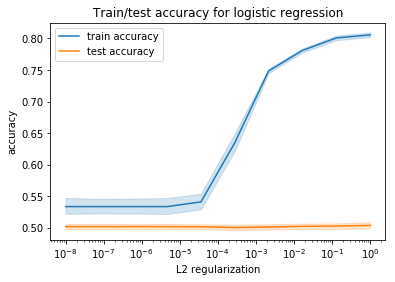

In [393]:
ax1= sns.lineplot(x='reg', y='train_acc', label='train accuracy', data=df)
ax1.set_xscale('log')
sns.lineplot(x='reg', y='test_acc', label='test accuracy', data=df, ax=ax1)
plt.ylabel("accuracy")
plt.xlabel("L2 regularization")
plt.title("Train/test accuracy for logistic regression")
plt.legend()
plt.show()

#### Visual Inspection

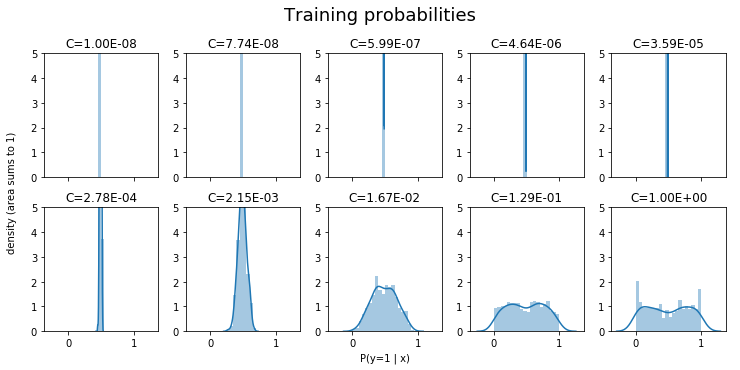

In [418]:
build_prob_plot(train_probs[0, :, :], "Training probabilities", 2,5, regularization, "C={:.2E}")

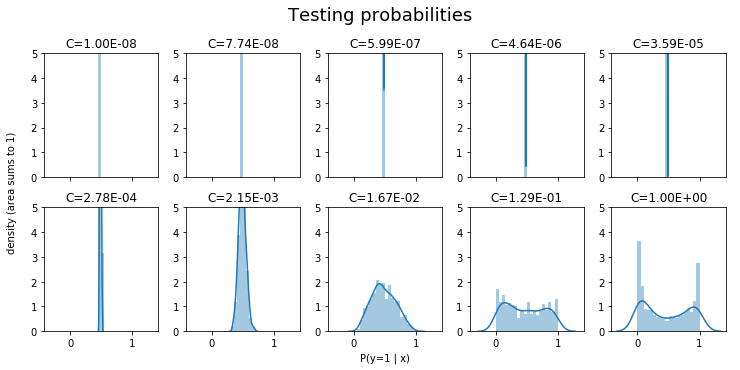

In [420]:
build_prob_plot(test_probs[0, :, :], "Testing probabilities", 2, 5, regularization, "C={:.2E}")

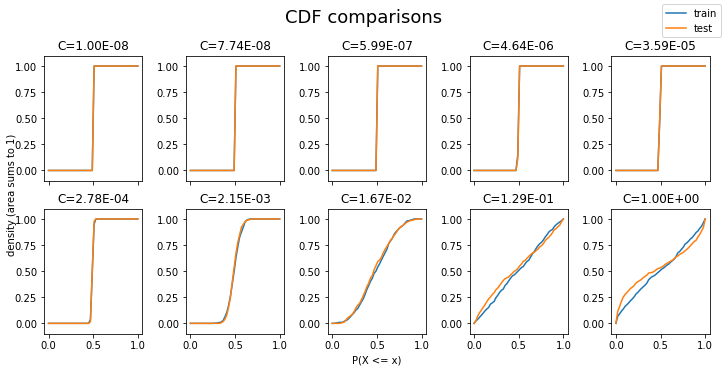

In [447]:
build_cdf_plot(train_probs[0, :, :], test_probs[0, :, :], "CDF comparisons", 2, 5, regularization, "C={:.2E}")

### Logistic Regression, varying regularization

- \# train = 500
- \# test = 500
- \# features = 200
- \# informative = 20
- \# noise features = 140
- balanced classes

In [486]:
# features
n_informative = 20
n_redundant = 20
n_repeated = 20
n_features = 200

# samples
n_train = 500
n_test = 500

# class parameters
n_classes = 2
weights = None#[.2, .8] # defaults to 50/50 split
flip_y = 0.05 # percentage of y's to flip

# output params
shuffle = True
random_state = 0
class_sep = 1
n_clusters_per_class = 1


regularization = np.logspace(-5, 5, num=11, base=10)

n_trials = 100


train_probs = np.zeros((n_trials, len(regularization), n_train))
test_probs = np.zeros((n_trials, len(regularization), n_test))
train_acc = np.zeros((n_trials, len(regularization)))
test_acc = np.zeros((n_trials, len(regularization)))



for idx, reg in enumerate(regularization):
    for trial in range(n_trials):
        # generate data
        train_X, train_y, \
        test_X, test_y = generate_class_data(n_train,
                                             n_test,
                                             n_features=n_features,
                                             n_informative=n_informative,
                                             n_repeated=n_repeated,
                                             n_redundant=n_redundant,
                                             flip_y = flip_y,
                                             random_state=trial)
        clf = LogisticRegression(solver='lbfgs', 
                                 penalty='l2',
                                 C=reg,
                                 max_iter=500)
        clf.fit(train_X, train_y)

        train_acc[trial, idx] = clf.score(train_X, train_y)
        test_acc[trial, idx] = clf.score(test_X, test_y)

        train_probs[trial, idx, :] = clf.predict_proba(train_X)[:, 0]
        test_probs[trial, idx, :] = clf.predict_proba(test_X)[:, 0] 
        
    print(idx)

0
1
2
3
4
5


/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. 

/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. 

6


/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. 

/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. 

7


/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. 

/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. 

8


/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. 

/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. 

9


/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. 

/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. 

10


/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


#### Visual Inspection

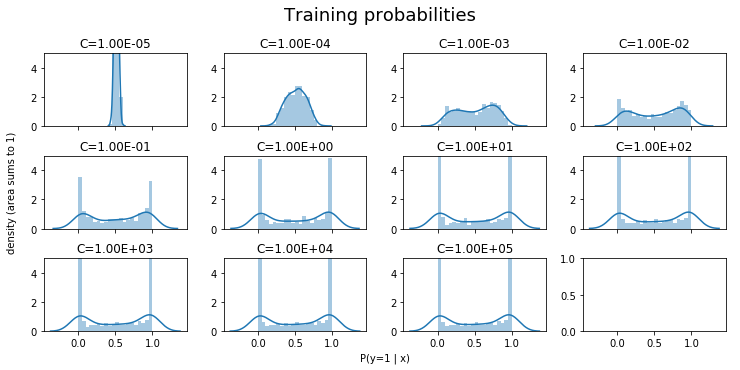

In [487]:
build_prob_plot(train_probs[0, :, :], "Training probabilities", 3,4, regularization, "C={:.2E}")

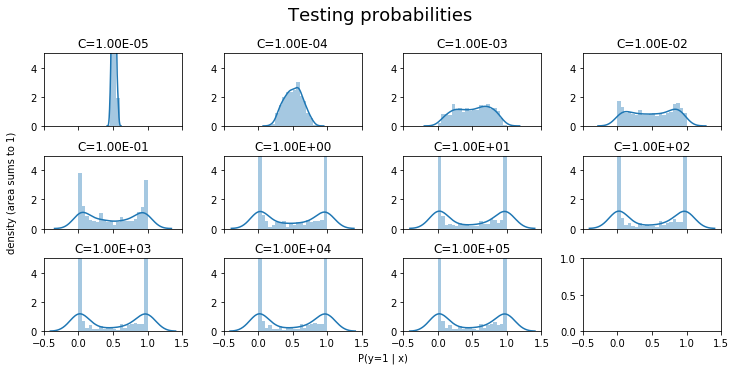

In [488]:
build_prob_plot(test_probs[0, :, :], "Testing probabilities", 3, 4, regularization, "C={:.2E}")

No handles with labels found to put in legend.


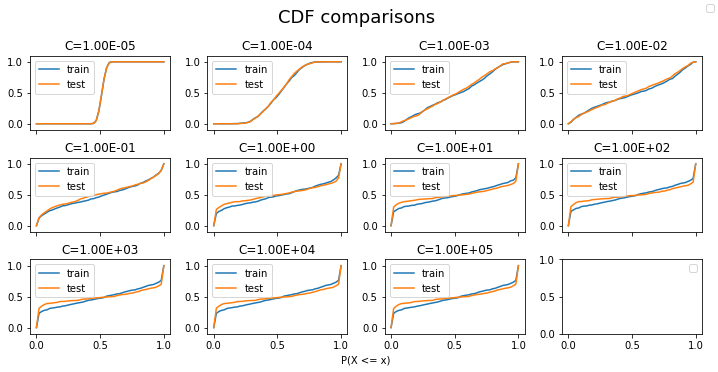

In [489]:
build_cdf_plot(train_probs[0, :, :], test_probs[0, :, :], "CDF comparisons", 3, 4, regularization, "C={:.2E}")

#### KS test

In [490]:
df = pd.DataFrame(columns=['reg', 'test_stat', 'p_val', 'train_acc', 'test_acc'])
for i, reg in enumerate(regularization):
    for trial in range(n_trials):
        D_test_stat, p_val = ks_2samp(train_probs[trial, i,:], test_probs[trial, i,:])
        df.loc[(i * n_trials) + trial] = [reg, D_test_stat, p_val, train_acc[trial, i], test_acc[trial, i]]


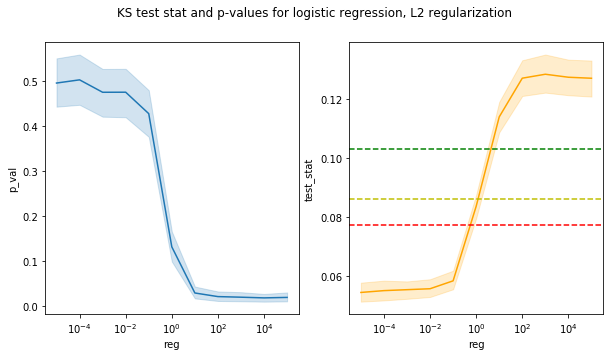

In [491]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5), sharex=True)

sns.lineplot(x='reg', y='p_val', data=df, ax=ax1)
plt.xlabel("Regularization")
ax1.set_xscale('log')
#plt.ylabel("p-value", color='blue')
#plt.title("KS test stat for logistic regression, L2 regularization")

sns.lineplot(x='reg', y='test_stat', color='orange', data=df, ax=ax2)
ax2.set_xscale('log')
#plt.ylabel("test statistic", color='orange')
plt.axhline(y=alpha10, label='alpha = 0.1', ls='--', color='r')
plt.axhline(y=alpha05, label='alpha = 0.05', ls='--', color='y')
plt.axhline(y=alpha01, label='alpha = 0.01', ls='--', color='g')
plt.suptitle("KS test stat and p-values for logistic regression, L2 regularization")
plt.show()

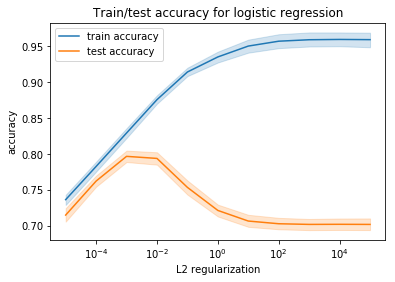

In [492]:
ax1= sns.lineplot(x='reg', y='train_acc', label='train accuracy', data=df)
ax1.set_xscale('log')
sns.lineplot(x='reg', y='test_acc', label='test accuracy', data=df, ax=ax1)
plt.ylabel("accuracy")
plt.xlabel("L2 regularization")
plt.title("Train/test accuracy for logistic regression")
plt.legend()
plt.show()

### Logistic Regression, zoomed in

In [479]:
# features
n_informative = 20
n_redundant = 20
n_repeated = 20
n_features = 200

# samples
n_train = 500
n_test = 500

# class parameters
n_classes = 2
weights = None#[.2, .8] # defaults to 50/50 split
flip_y = 0.05 # percentage of y's to flip

# output params
shuffle = True
random_state = 0
class_sep = 1
n_clusters_per_class = 1


regularization = np.logspace(-3, 1, num=16, base=10)

n_trials = 100


train_probs = np.zeros((n_trials, len(regularization), n_train))
test_probs = np.zeros((n_trials, len(regularization), n_test))
train_acc = np.zeros((n_trials, len(regularization)))
test_acc = np.zeros((n_trials, len(regularization)))



for idx, reg in enumerate(regularization):
    for trial in range(n_trials):
        # generate data
        train_X, train_y, \
        test_X, test_y = generate_class_data(n_train,
                                             n_test,
                                             n_features=n_features,
                                             n_informative=n_informative,
                                             n_repeated=n_repeated,
                                             n_redundant=n_redundant,
                                             flip_y = flip_y,
                                             random_state=trial)
        clf = LogisticRegression(solver='lbfgs', 
                                 penalty='l2',
                                 C=reg,
                                 max_iter=500)
        clf.fit(train_X, train_y)

        train_acc[trial, idx] = clf.score(train_X, train_y)
        test_acc[trial, idx] = clf.score(test_X, test_y)

        train_probs[trial, idx, :] = clf.predict_proba(train_X)[:, 0]
        test_probs[trial, idx, :] = clf.predict_proba(test_X)[:, 0] 
        
    print(idx)

0
1
2
3
4
5
6
7
8
9
10
11
12


/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


13


/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. 

14


/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. 

/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. 

15


/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


#### Visual Inspection

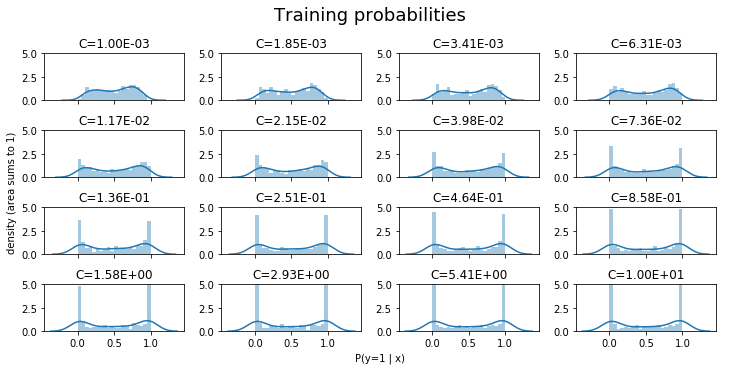

In [480]:
build_prob_plot(train_probs[0, :, :], "Training probabilities", 4,4, regularization, "C={:.2E}")

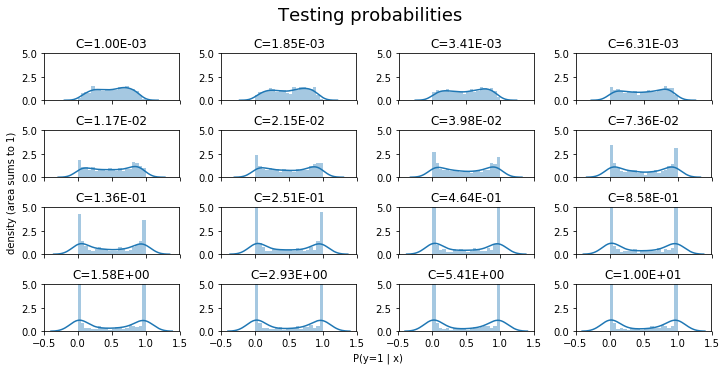

In [481]:
build_prob_plot(test_probs[0, :, :], "Testing probabilities", 4, 4, regularization, "C={:.2E}")

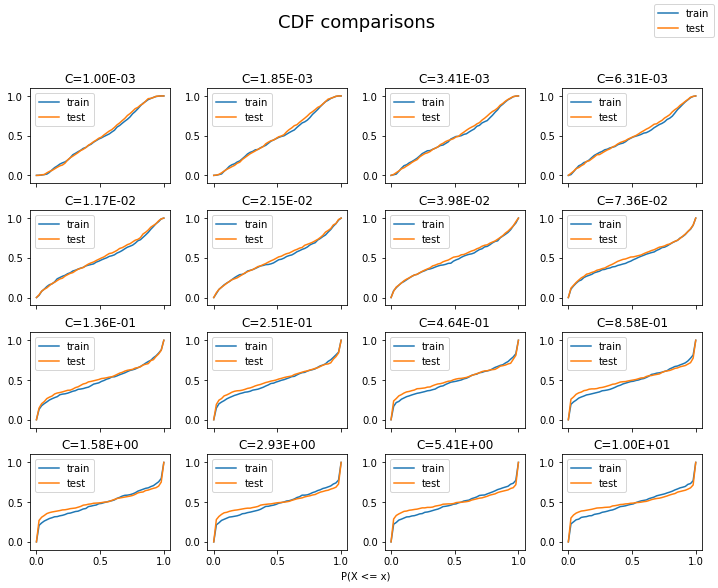

In [482]:
build_cdf_plot(train_probs[0, :, :], test_probs[0, :, :], "CDF comparisons", 4, 4, regularization, "C={:.2E}", fig_size=(10, 8))

#### KS test

In [483]:
df = pd.DataFrame(columns=['reg', 'test_stat', 'p_val', 'train_acc', 'test_acc'])
for i, reg in enumerate(regularization):
    for trial in range(n_trials):
        D_test_stat, p_val = ks_2samp(train_probs[trial, i,:], test_probs[trial, i,:])
        df.loc[(i * n_trials) + trial] = [reg, D_test_stat, p_val, train_acc[trial, i], test_acc[trial, i]]


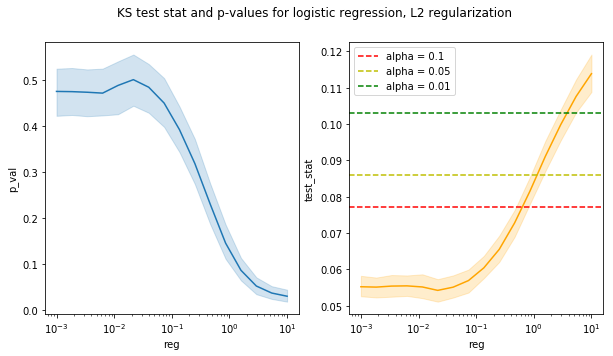

In [484]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5), sharex=True)

sns.lineplot(x='reg', y='p_val', data=df, ax=ax1)
plt.xlabel("Regularization")
ax1.set_xscale('log')
#plt.ylabel("p-value", color='blue')
#plt.title("KS test stat for logistic regression, L2 regularization")

sns.lineplot(x='reg', y='test_stat', color='orange', data=df, ax=ax2)
ax2.set_xscale('log')
#plt.ylabel("test statistic", color='orange')
plt.axhline(y=alpha10, label='alpha = 0.1', ls='--', color='r')
plt.axhline(y=alpha05, label='alpha = 0.05', ls='--', color='y')
plt.axhline(y=alpha01, label='alpha = 0.01', ls='--', color='g')

plt.suptitle("KS test stat and p-values for logistic regression, L2 regularization")
plt.legend()
plt.show()

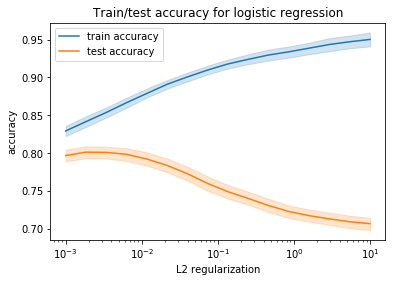

In [485]:
ax1= sns.lineplot(x='reg', y='train_acc', label='train accuracy', data=df)
ax1.set_xscale('log')
sns.lineplot(x='reg', y='test_acc', label='test accuracy', data=df, ax=ax1)
plt.ylabel("accuracy")
plt.xlabel("L2 regularization")
plt.title("Train/test accuracy for logistic regression")
plt.legend()
plt.show()

### Logistic Regression, zoomed in with more testing samples

In [511]:
# features
n_informative = 20
n_redundant = 20
n_repeated = 20
n_features = 200

# samples
n_train = 500
n_test = 10000

# class parameters
n_classes = 2
weights = None#[.2, .8] # defaults to 50/50 split
flip_y = 0.05 # percentage of y's to flip

# output params
shuffle = True
random_state = 0
class_sep = 1
n_clusters_per_class = 1


regularization = np.logspace(-3, 1, num=16, base=10)

n_trials = 100


train_probs = np.zeros((n_trials, len(regularization), n_train))
test_probs = np.zeros((n_trials, len(regularization), n_test))
train_acc = np.zeros((n_trials, len(regularization)))
test_acc = np.zeros((n_trials, len(regularization)))



for idx, reg in enumerate(regularization):
    for trial in range(n_trials):
        # generate data
        train_X, train_y, \
        test_X, test_y = generate_class_data(n_train,
                                             n_test,
                                             n_features=n_features,
                                             n_informative=n_informative,
                                             n_repeated=n_repeated,
                                             n_redundant=n_redundant,
                                             flip_y = flip_y,
                                             random_state=trial)
        clf = LogisticRegression(solver='lbfgs', 
                                 penalty='l2',
                                 C=reg,
                                 max_iter=500)
        clf.fit(train_X, train_y)

        train_acc[trial, idx] = clf.score(train_X, train_y)
        test_acc[trial, idx] = clf.score(test_X, test_y)

        train_probs[trial, idx, :] = clf.predict_proba(train_X)[:, 0]
        test_probs[trial, idx, :] = clf.predict_proba(test_X)[:, 0] 
        
    print(idx)

0
1
2
3
4
5
6
7
8
9
10
11
12


/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


13


/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. 

14


/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. 

/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. 

15


/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


#### Visual Inspection

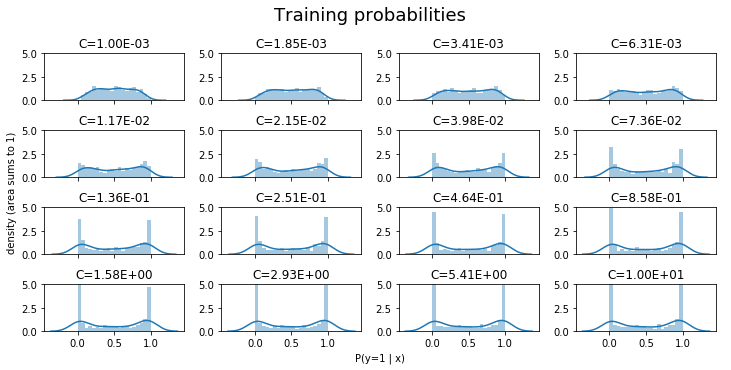

In [512]:
build_prob_plot(train_probs[0, :, :], "Training probabilities", 4,4, regularization, "C={:.2E}")

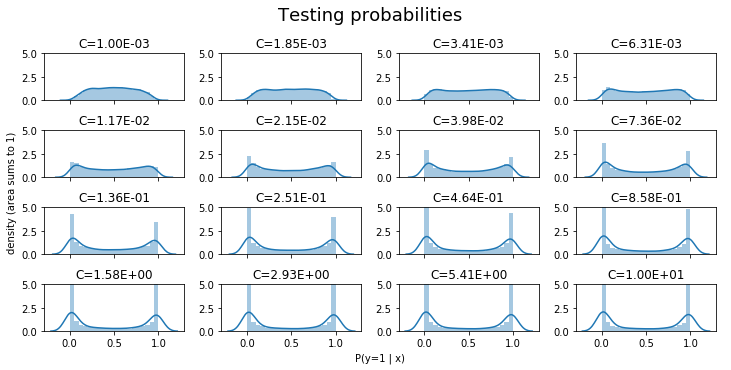

In [513]:
build_prob_plot(test_probs[0, :, :], "Testing probabilities", 4, 4, regularization, "C={:.2E}")

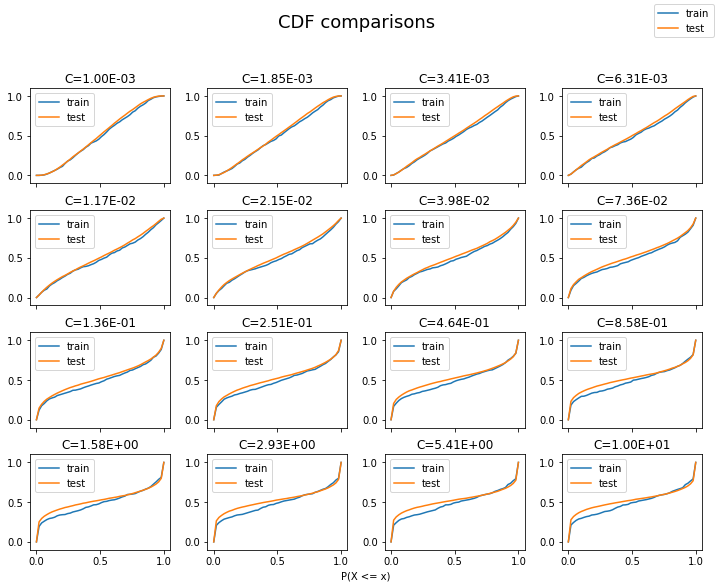

In [514]:
build_cdf_plot(train_probs[0, :, :], test_probs[0, :, :], "CDF comparisons", 4, 4, regularization, "C={:.2E}", fig_size=(10, 8))

#### KS test

In [515]:
df = pd.DataFrame(columns=['reg', 'test_stat', 'p_val', 'train_acc', 'test_acc'])
for i, reg in enumerate(regularization):
    for trial in range(n_trials):
        D_test_stat, p_val = ks_2samp(train_probs[trial, i,:], test_probs[trial, i,:])
        df.loc[(i * n_trials) + trial] = [reg, D_test_stat, p_val, train_acc[trial, i], test_acc[trial, i]]


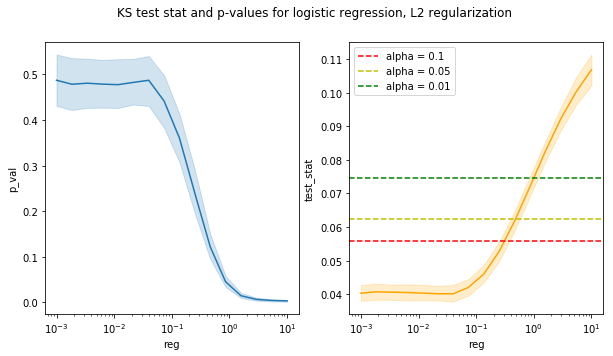

In [519]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5), sharex=True)

sns.lineplot(x='reg', y='p_val', data=df, ax=ax1)
plt.xlabel("Regularization")
ax1.set_xscale('log')
#plt.ylabel("p-value", color='blue')
#plt.title("KS test stat for logistic regression, L2 regularization")

sns.lineplot(x='reg', y='test_stat', color='orange', data=df, ax=ax2)
ax2.set_xscale('log')
#plt.ylabel("test statistic", color='orange')
plt.axhline(y=alpha10, label='alpha = 0.1', ls='--', color='r')
plt.axhline(y=alpha05, label='alpha = 0.05', ls='--', color='y')
plt.axhline(y=alpha01, label='alpha = 0.01', ls='--', color='g')

plt.suptitle("KS test stat and p-values for logistic regression, L2 regularization")
plt.legend()
plt.show()

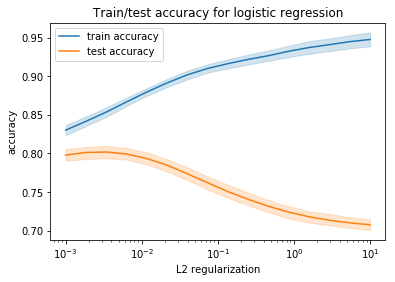

In [517]:
ax1= sns.lineplot(x='reg', y='train_acc', label='train accuracy', data=df)
ax1.set_xscale('log')
sns.lineplot(x='reg', y='test_acc', label='test accuracy', data=df, ax=ax1)
plt.ylabel("accuracy")
plt.xlabel("L2 regularization")
plt.title("Train/test accuracy for logistic regression")
plt.legend()
plt.show()

### Short Abstract

**Detecting Overfitting using Unlabelled Data**


Machine learning algorithms are becoming more prevalent in medicine, and it is important to be able to detect overfitting to ensure that they generalize. Typical procedures for identifying overfitting involve measuring performance on previously unseen data. However, this requires having ground truth labels for the held-out sample which may be expensive to acquire, particularly in the medical domain. Here, we demonstrate that overfitting can be detected using only unlabelled samples by comparing the distributions of predictions the model makes on the training set and held-out set. We present a hypothesis test for this comparison and validate its effectivenss on both simulated and real data. The ability to detect overfitting will be critical in resource-constrained domains like medicine, where erroneous models could mislead physicians.

### Sandbox

In [333]:
def critical_value(alpha, n1, n2):
    """Calculates the critical at the given alpha level and sample sizes.
    
    Per the calculation here: https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test#Two-sample_Kolmogorov%E2%80%93Smirnov_test
    """
    c = np.sqrt(-0.5 * np.log(alpha))
    crit_val = c * np.sqrt((n1+n2) / (n1*n2))
    
    return crit_val

In [518]:
alpha10 = 1.22 * np.sqrt((n_test + n_train) / (n_test * n_train))
alpha05 = 1.36 * np.sqrt((n_test + n_train) / (n_test * n_train))
alpha01 = 1.63 * np.sqrt((n_test + n_train) / (n_test * n_train))

In [521]:
1.22 * np.sqrt(1/n_train)

0.05456005865099487